## 4_DATA_PREPROCESSING
수집된 데이터를 전처리(결측치 보간, 전처리 등)을 진행하는 과정입니다.

## 기본 설정

In [1]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

! pip install {USER_FLAG} --upgrade google-cloud-aiplatform
! pip install {USER_FLAG} --upgrade google-cloud-storage
!pip install wget

In [2]:
# 설치가 끝나면 커널을 재시작해야합니다.
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

In [1]:
# 세팅을 다시 로드
import os
import pandas as pd

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
import warnings
import os
import joblib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from google.cloud import aiplatform, storage

from google.cloud import storage
from google.cloud import bigquery

import pandas as pd
from sklearn import datasets

PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
    
# 지역, GCS 클라이언트, BQ 클라이언트 설정
REGION = 'asia-northeast3'
gcs = storage.Client(project = PROJECT_ID)
bq = bigquery.Client(project = PROJECT_ID)

# bucket 이름 지정: "프로젝트 이름-bucket"
BUCKET_NAME=PROJECT_ID + "-bucket"
if not gcs.lookup_bucket(BUCKET_NAME):
    bucketDef = gcs.bucket(BUCKET_NAME)
    bucket = gcs.create_bucket(bucketDef, project=PROJECT_ID, location=REGION)
    print(bucket)
else:
    print(gcs.lookup_bucket(BUCKET_NAME))
    
def get_dataframe(bq_table):
    
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    project_number = shell_output[0]
    bqclient = bigquery.Client(project=project_number)
    
    table = bigquery.TableReference.from_string(
        project_number+"."+bq_table
    )
    
    rows = bqclient.list_rows(
        table
    )
    
    dataframe = rows.to_dataframe(
        create_bqstorage_client=True,
    )

    return dataframe
def to_bigquery(
    dataframe,
    table_name: str,
    bucket_name: str
):
    client = bigquery.Client()
    column_list=dataframe.columns
    query_column_list=""
    
    #blob = storage.blob.Blob.from_string(f"""gs://{bucket_name}/{table_name.split(".")[-1]}.csv""", client=storage.Client())
    dataframe.to_csv(f"""gs://{bucket_name}/{table_name.split(".")[-1]}.csv""",index=False,encoding="utf-8")
    #blob.upload_from_file(temp)
    
    for name in column_list:
        query_column_list=query_column_list+name+" STRING,"
        
    query = f"""
    LOAD DATA OVERWRITE {table_name}(
    {query_column_list}
        )
    FROM FILES (
      skip_leading_rows=1,
      allow_jagged_rows=true,
      format = 'CSV',
      encoding='utf-8',
      field_delimiter=',',
      uris = ['gs://{bucket_name}/{table_name.split(".")[-1]}.csv']);"""
    
    query_job = client.query(query)
    results = query_job.result()

Project ID:  bigfesta2022-esg-team6-proj
<Bucket: bigfesta2022-esg-team6-proj-bucket>


## 데이터 취합

- 지배구조: 테이블 추출로 수집한 데이터(govern_table)와 수기로 수집한 테이블 데이블() 취합
- 사회: 테이블 추출로 수집한 데이터

In [16]:
import pandas as pd
total_final=get_dataframe("common.total_corp_final")

In [17]:
govern_table=pd.read_csv("data/pipeline3/govern_table.csv")
govern_dart=pd.read_csv("data/pipeline3/govern_Dart.csv")
govern_dart=govern_dart[["code","Outer_percentage","female_percentage"]]
govern_table=govern_table[['code', 'vote_y', 'vote_n', 'vote_percentage', 'attendance','op_uniformity', 'audit_num', 'report_exist']]
corp_govern_total=pd.merge(total_final,govern_dart, on='code',how="left")
corp_govern_total=pd.merge(corp_govern_total,govern_table, on='code',how="left")
corp_govern_total

,code,name,market,kor_name,eng_name,stock_corp_code,stock_name,industry_code,industry_med_code,industry_sub_code,...,asset_sum,Outer_percentage,female_percentage,vote_y,vote_n,vote_percentage,attendance,op_uniformity,audit_num,report_exist
0,'002270',롯데푸드,KOSPI,None,None,None,None,None,None,None,...,1432425854920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,'101060',SBS미디어홀딩스,KOSPI,None,None,None,None,None,None,None,...,414859244550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,'007630',폴루스바이오팜,KOSPI,None,None,None,None,None,None,None,...,147934874220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,'015350',부산가스,KOSPI,None,None,None,None,None,None,None,...,1125953897420.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,'138250',엔에스쇼핑,KOSPI,None,None,None,None,None,None,None,...,1005654282030.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,'011420',갤럭시아에스엠,KOSPI,(주)갤럭시아 에스엠,"Galaxia SM, INC.",'00129554',갤럭시아에스엠,'911','91','911',...,44751172550.0,0.250000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,False
943,'035250',강원랜드,KOSPI,(주)강원랜드,"Kangwon Land, Inc.",'00255619',강원랜드,'91249','91','912',...,3792380948640.0,0.692308,0.076923,0.0,6.0,0.0,94.529412,97.017647,2.0,True
944,'114090',GKL,KOSPI,그랜드코리아레저(주),"Grand Korea Leisure Co.,Ltd",'00557508',GKL,'91249','91','912',...,521234715880.0,0.545455,0.181818,NaN,NaN,NaN,NaN,NaN,NaN,False
945,'034230',파라다이스,KOSDAQ,(주)파라다이스,Paradise Company Limited,'00171265',파라다이스,'91249','91','912',...,1699801632360.0,0.400000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,False


In [18]:
social_dart=pd.read_csv("data/pipeline3/social_Dart.csv")
social_table=pd.read_csv("data/pipeline3/social_table.csv")
social_table=social_table[['code','report_exist', 'disabled', 'industry_accident', 'volunteer']]
social_dart=social_dart[['code', 'reg_prob', 'female_prob', 'reg_female_prob',
       'female_money_prob']]
corp_social_total=pd.merge(total_final,social_dart, on='code',how="left")
corp_social_total=pd.merge(corp_social_total,social_table, on='code',how="left")
corp_social_total

,code,name,market,kor_name,eng_name,stock_corp_code,stock_name,industry_code,industry_med_code,industry_sub_code,...,industry_sub_name,asset_sum,reg_prob,female_prob,reg_female_prob,female_money_prob,report_exist,disabled,industry_accident,volunteer
0,'002270',롯데푸드,KOSPI,None,None,None,None,None,None,None,...,None,1432425854920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,'101060',SBS미디어홀딩스,KOSPI,None,None,None,None,None,None,None,...,None,414859244550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,'007630',폴루스바이오팜,KOSPI,None,None,None,None,None,None,None,...,None,147934874220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,'015350',부산가스,KOSPI,None,None,None,None,None,None,None,...,None,1125953897420.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,'138250',엔에스쇼핑,KOSPI,None,None,None,None,None,None,None,...,None,1005654282030.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,'011420',갤럭시아에스엠,KOSPI,(주)갤럭시아 에스엠,"Galaxia SM, INC.",'00129554',갤럭시아에스엠,'911','91','911',...,스포츠 서비스업,44751172550.0,0.532609,0.152174,0.163265,0.568627,NaN,NaN,NaN,NaN
943,'035250',강원랜드,KOSPI,(주)강원랜드,"Kangwon Land, Inc.",'00255619',강원랜드,'91249','91','912',...,유원지 및 기타 오락관련 서비스업,3792380948640.0,0.981431,0.100413,0.088998,0.900200,True,90.0,0.33,4.3
944,'114090',GKL,KOSPI,그랜드코리아레저(주),"Grand Korea Leisure Co.,Ltd",'00557508',GKL,'91249','91','912',...,유원지 및 기타 오락관련 서비스업,521234715880.0,0.997719,0.544470,0.545714,0.887572,NaN,NaN,NaN,NaN
945,'034230',파라다이스,KOSDAQ,(주)파라다이스,Paradise Company Limited,'00171265',파라다이스,'91249','91','912',...,유원지 및 기타 오락관련 서비스업,1699801632360.0,0.968821,0.439544,0.446625,0.833697,NaN,NaN,NaN,NaN


In [19]:
environ_2018=pd.read_csv("data/pipeline3/environ_2018.csv")
environ_2019=pd.read_csv("data/pipeline3/environ_2019.csv")
environ_2020=pd.read_csv("data/pipeline3/environ_2020.csv")
environ_2018=environ_2018[['code', 'year', 'raw', 'water', 'energy', 'air_pollu', 'water_pollu',
       'waste', 'chemical', 'water_reuse', 'waste_reuse']]
environ_2019=environ_2019[['code', 'year', 'raw', 'water', 'energy', 'air_pollu', 'water_pollu',
       'waste', 'chemical', 'water_reuse', 'waste_reuse']]
environ_2020=environ_2020[['code', 'year', 'raw', 'water', 'energy', 'air_pollu', 'water_pollu',
       'waste', 'chemical', 'water_reuse', 'waste_reuse']]
environ_total=pd.concat([environ_2018,environ_2019,environ_2020],axis=0)
environ_total.reset_index(inplace=True,drop=True)
corp_environ_total=pd.merge(environ_total, total_final, on='code',how="right")
corp_environ_total=corp_environ_total[['code','name',  'market','year','stock_corp_code', 'stock_name','kor_name', 'eng_name', 'industry_code', 'industry_med_code', 'industry_sub_code','industry_med_name', 'industry_sub_name' ,"asset_sum",'raw', 'water', 'energy', 'air_pollu', 'water_pollu','waste', 'chemical', 'water_reuse', 'waste_reuse']]
corp_environ_total

,code,name,market,year,stock_corp_code,stock_name,kor_name,eng_name,industry_code,industry_med_code,...,asset_sum,raw,water,energy,air_pollu,water_pollu,waste,chemical,water_reuse,waste_reuse
0,'002270',롯데푸드,KOSPI,2018,None,None,None,None,None,None,...,1432425854920.0,1146162.113,6681341.0,6200.010,30.78874,874.75104,76911.013,5.297,193098.0,52954.063
1,'002270',롯데푸드,KOSPI,2019,None,None,None,None,None,None,...,1432425854920.0,0.000,0.0,0.000,0.00000,0.00000,0.000,0.000,0.0,0.000
2,'002270',롯데푸드,KOSPI,2020,None,None,None,None,None,None,...,1432425854920.0,0.000,0.0,0.000,0.00000,0.00000,0.000,0.000,0.0,0.000
3,'101060',SBS미디어홀딩스,KOSPI,2018,None,None,None,None,None,None,...,414859244550.0,0.000,0.0,0.000,0.00000,0.00000,0.000,0.000,0.0,0.000
4,'101060',SBS미디어홀딩스,KOSPI,2019,None,None,None,None,None,None,...,414859244550.0,0.000,0.0,0.000,0.00000,0.00000,0.000,0.000,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2836,'034230',파라다이스,KOSDAQ,2019,'00171265',파라다이스,(주)파라다이스,Paradise Company Limited,'91249','91',...,1699801632360.0,0.000,854290.0,918.111,0.00000,0.03572,3287.369,5.000,0.0,1548.508
2837,'034230',파라다이스,KOSDAQ,2020,'00171265',파라다이스,(주)파라다이스,Paradise Company Limited,'91249','91',...,1699801632360.0,0.000,348469.0,453.508,0.00000,0.00000,1139.369,0.000,0.0,575.508
2838,'021240',코웨이,KOSPI,2018,'00170558',코웨이,코웨이(주),"COWAY Co., Ltd.",'969','96',...,3443217159720.0,0.000,0.0,0.000,0.00000,0.00000,0.000,0.000,0.0,0.000
2839,'021240',코웨이,KOSPI,2019,'00170558',코웨이,코웨이(주),"COWAY Co., Ltd.",'969','96',...,3443217159720.0,0.000,0.0,0.000,0.00000,0.00000,0.000,0.000,0.0,0.000


In [21]:
corp_environ_total.to_csv("data/pipeline3/esg_environ_total.csv",encoding="utf-8",index=False)
corp_govern_total.to_csv("data/pipeline3/esg_govern_total.csv",encoding="utf-8",index=False)
corp_social_total.to_csv("data/pipeline3/esg_social_total.csv",encoding="utf-8",index=False)

## 데이터 전처리

In [22]:
import pandas as pd
social_final=pd.read_csv("data/pipeline3/esg_social_total.csv")
environ_final=pd.read_csv("data/pipeline3/esg_environ_total.csv")
govern_final=pd.read_csv("data/pipeline3/esg_govern_total.csv")

### 1. exist 열 추가

In [23]:
govern_final=govern_final.rename(columns={"report_exist":"exist"})

In [24]:
social_final=social_final.rename(columns={"report_exist":"exist"})
social_final["exist"]=social_final["exist"].fillna(False)

In [25]:
environ_final['exist'] = [0 if t else 1 for t in list(environ_final[['raw',
       'water', 'energy', 'air_pollu', 'water_pollu', 'waste', 'chemical',
       'water_reuse', 'waste_reuse']].sum(axis=1)==0)]

In [26]:
environ_temp=pd.DataFrame(environ_final.groupby(["code"]).agg({"raw":"mean","water":"mean","energy":"mean",
                                                                      "air_pollu":"mean","water_pollu":"mean","waste":"mean",
                                                                      "chemical":"mean","water_reuse":"mean","waste_reuse":"mean",
                                                                      "exist":"sum"}))
environ_temp["code"]=environ_temp.index
environ_temp.reset_index(inplace=True, drop=True)
environ_final=pd.merge(environ_final[['code', 'name', 'market', 'stock_corp_code', 'stock_name',
       'kor_name', 'eng_name', 'industry_code', 'industry_med_code',
       'industry_sub_code', 'industry_med_name', 'industry_sub_name','asset_sum']].groupby(["code"]).head(1).reset_index(drop=True),environ_temp,on="code",how="left")

### 2. asset_sum 추가

In [27]:
## 자본총계의 사분위수 기준으로 가장 부자인 기업부터 1 , 2 , 3 , 4 의 값 부여
## 0~25% : 1 / 25~50% : 2 / 50~75% : 3 / 75%~100% : 4

## 환경 데이터

cutoff_1 = 0.25
cutoff_2 = 0.50
cutoff_3 = 0.75

## 컷오프포인트를 기준으로 각각의 분위수에 해당하는 수를 구합니다.
Q1 = environ_final['asset_sum'].quantile(cutoff_1)
Q2 = environ_final['asset_sum'].quantile(cutoff_2)
Q3 = environ_final['asset_sum'].quantile(cutoff_3)

asset_sum_cat = [] 
## 앞서 구한 분위수를 기준으로 기업의 asset_sum 항목의 값에 따라 1, 2, 3, 4의 범주를 부여합니다.(1 : 가장 높은 asset_sum을 가진 기업 / 4 : 가장 낮은 asset_sum을 가진 기업)
for i in range(len(environ_final['asset_sum'])):
    if(environ_final['asset_sum'][i] < Q1):
        asset_sum_cat.append(4)
    elif((environ_final['asset_sum'][i] >= Q1) & (environ_final['asset_sum'][i] < Q2)):
        asset_sum_cat.append(3)
    elif((environ_final['asset_sum'][i] >= Q2) & (environ_final['asset_sum'][i] < Q3)):
        asset_sum_cat.append(2)
    elif(environ_final['asset_sum'][i] >= Q3):
        asset_sum_cat.append(1)

environ_final['asset_sum_cat'] = asset_sum_cat

## 같은 과정을 사회, 지배구조 데이터에도 적용합니다.

## 자본총계의 사분위수 기준으로 가장 부자인 기업부터 1 , 2 , 3 , 4 의 값 부여
## 0~25% : 1 / 25~50% : 2 / 50~75% : 3 / 75%~100% : 4

## 사회 데이터

cutoff_1 = 0.25
cutoff_2 = 0.50
cutoff_3 = 0.75


Q1 = social_final['asset_sum'].quantile(cutoff_1)
Q2 = social_final['asset_sum'].quantile(cutoff_2)
Q3 = social_final['asset_sum'].quantile(cutoff_3)

asset_sum_cat = []
for i in range(len(social_final['asset_sum'])):
    if(social_final['asset_sum'][i] < Q1):
        asset_sum_cat.append(4)
    elif((social_final['asset_sum'][i] >= Q1) & (social_final['asset_sum'][i] < Q2)):
        asset_sum_cat.append(3)
    elif((social_final['asset_sum'][i] >= Q2) & (social_final['asset_sum'][i] < Q3)):
        asset_sum_cat.append(2)
    elif(social_final['asset_sum'][i] >= Q3):
        asset_sum_cat.append(1)

social_final['asset_sum_cat'] = asset_sum_cat

## 자본총계의 사분위수 기준으로 가장 부자인 기업부터 1 , 2 , 3 , 4 의 값 부여
## 0~25% : 1 / 25~50% : 2 / 50~75% : 3 / 75%~100% : 4

## 지배구조 데이터

cutoff_1 = 0.25
cutoff_2 = 0.50
cutoff_3 = 0.75


Q1 = govern_final['asset_sum'].quantile(cutoff_1)
Q2 = govern_final['asset_sum'].quantile(cutoff_2)
Q3 = govern_final['asset_sum'].quantile(cutoff_3)

asset_sum_cat = []
for i in range(len(govern_final['asset_sum'])):
    if(govern_final['asset_sum'][i] < Q1):
        asset_sum_cat.append(4)
    elif((govern_final['asset_sum'][i] >= Q1) & (govern_final['asset_sum'][i] < Q2)):
        asset_sum_cat.append(3)
    elif((govern_final['asset_sum'][i] >= Q2) & (govern_final['asset_sum'][i] < Q3)):
        asset_sum_cat.append(2)
    elif(govern_final['asset_sum'][i] >= Q3):
        asset_sum_cat.append(1)

govern_final['asset_sum_cat'] = asset_sum_cat

In [28]:
!pip install dart-fss

In [17]:
import dart_fss as dart
from dart_fss import get_corp_list
key='c76b1f22ef317617c15f5c3efa535c9540a374eb'

dart.set_api_key(api_key=key) ## api 인증키를 설정합니다.

crp_list = get_corp_list() ## 기업 리스트를 dart에서 받아옵니다.

Output()

Output()

Output()

In [ ]:
## 사회데이터 개별 전처리
## 1.향후 전처리를 위해 dart에서 총 직원수 가져오기
## dart.api.info.emp_sttus를 통해 각 기업의 남성, 여성 총 직원수를 가져옵니다.


df1 = pd.DataFrame(columns = ["code" , "M_sm" , "F_sm"])
sm = []

for i, stock_code in enumerate(social_final["code"]):
    try : ## 해당 code가 NaN이 아니라면
        stock_code_new = stock_code.replace("'","")
        try : ## crp_list에 해당 stock_code를 가진 기업이 있다면
            corp_code = crp_list.find_by_stock_code(stock_code_new).corp_code
            ## print(corp_code)
            result = dart.api.info.emp_sttus(corp_code, bsns_year = '2021', reprt_code = '11011', api_key = key)
            result = pd.DataFrame(result['list'])
            df1.loc[i] = [social_final["code"][i],result['sm'][0],result['sm'][1]] ## result['sm']을 통해 기업의 총 남성/여성 직원 수를 추출
        
        except :
            df1.loc[i] = [social_final['code'][i],np.NaN,np.NaN]
    except :
        df1.loc[i] = [social_final['code'][i],np.NaN,np.NaN]

## 1,324와 같이 숫자에 , 가 들어있어 문자로 인식되므로 , 를 제거하는 전처리 과정을 수행합니다.
df1['M_sm']= df1['M_sm'].str.replace(',', '')
df1['F_sm']= df1['F_sm'].str.replace(',', '')

## for문을 통해 사회 데이터에 기업별 총 직원수 파생변수를 추가합니다.
for j in range(len(df1['code'])):
    try :
        sm.append(float(df1['M_sm'][j]) + float(df1['F_sm'][j]))
    except :
        sm.append(0)
social_final['sm'] = sm

In [32]:
## 2. 장애인 고용비율 / 인당 봉사시간 전처리
## 장애인 고용비율은 지금 고용인원으로 되어있는데 sm으로 나눠서 고용비율로 나누어야 합니다.
## 이미 고용비율로 데이터가 뽑힌 것들이 있어서
## 우선 1로 나눈 나머지가 0이 아닌(자연수가 아닌) 수치부터(고용비율로 뽑힌 수치들) 역으로 sm을 곱해서 기업별 장애인 총 인원으로 바꾸고
## 그 후에 다시 sm(총 직원수)로 일괄적으로 나눠서 전처리 진행

## 이미 비율로 뽑힌 데이터에 대해서 sm을 곱하여 전체 데이터가 장애인 명수가 되게끔 전처리
for i in range(len(social_final['disabled'])):
    if((social_final['disabled'][i] % 1) != 0): ## 이미 비율로 되어있으면
        social_final['disabled'][i] = (social_final['disabled'][i] * social_final['sm'][i])

## 그 후 전체 데이터를 총 직원수로 나눠서 기업별 장애인 고용비율을 획득
for j in range(len(social_final['disabled'])):
    if(social_final['sm'][j] != 0):
        social_final['disabled'][j] = (social_final['disabled'][j] / social_final['sm'][j])
    else :
        social_final['disabled'][j] = 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [33]:
## 3. 같은 방식으로 인당 봉사시간도 100 넘어가는 수치들(총 봉사시간으로 뽑힌 기업)만 sm으로 나눠서 기업별 인당봉사시간으로 전처리
for i in range(len(social_final['volunteer'])):
    if(social_final['volunteer'][i] > 100): 
        if(social_final['sm'][i] != 0):
            social_final['volunteer'][i] = (social_final['volunteer'][i] / social_final['sm'][i])
        else :
            social_final['volunteer'][i] = 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [34]:
####  범주화 전 임시저장
environ_final.to_csv("data/pipeline3/esg_environ_final_raw.csv",encoding="utf-8",index=False)
govern_final.to_csv("data/pipeline3/esg_govern_final_raw.csv",encoding="utf-8",index=False)
social_final.to_csv("data/pipeline3/esg_social_final_raw.csv",encoding="utf-8",index=False)

### 3. 카테고리화

In [75]:
environ_final=pd.read_csv("data/pipeline3/esg_environ_final_raw.csv")
govern_final=pd.read_csv("data/pipeline3/esg_govern_final_raw.csv")
social_final=pd.read_csv("data/pipeline3/esg_social_final_raw.csv")

In [77]:
## 사회 파생변수 범주화 진행

## 사회 파생변수를 범주화할때, K-ESG가이드라인에 범주별로 부여하는 점수가 명시된 경우와 그렇지 않은 경우를 고려하여
## 해당 변수의 PLOT을 그려보고 적절한 CUT-OFF POINTS를 선정하여 범주화를 진행합니다.
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(0.0, 1.0)

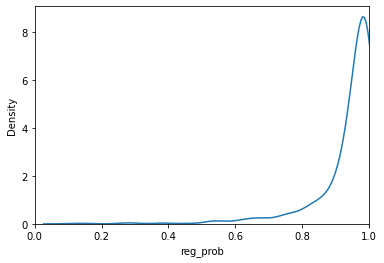

In [78]:
## reg_prob
sns.distplot(social_final.loc[social_final['reg_prob'].notnull(), 'reg_prob'], hist=False)
plt.xlim(0,1)
## 0 : 결측치 / 1 : 0 - 0.75 / 2 : 0.75 - 0.85 / 3 : 0.85 - 0.95 / 4 : 0.95 - 1 로 범주화

In [79]:
## 0 : 결측치 / 1 : 0 - 0.75 / 2 : 0.75 - 0.85 / 3 : 0.85 - 0.95 / 4 : 0.95 - 1 로 범주화

for i in range(len(social_final['reg_prob'])):
    if((social_final['reg_prob'][i] >= 0) & (social_final['reg_prob'][i] <= 0.75)):
        social_final['reg_prob'][i] = 1
    elif((social_final['reg_prob'][i] > 0.75) & (social_final['reg_prob'][i] <= 0.85)):
        social_final['reg_prob'][i] = 2
    elif((social_final['reg_prob'][i] > 0.85) & (social_final['reg_prob'][i] <= 0.95)):
        social_final['reg_prob'][i] = 3
    elif(social_final['reg_prob'][i] > 0.95):
        social_final['reg_prob'][i] = 4
    else :
        social_final['reg_prob'][i] = 0

## 각 범주를 가진 기업의 개수가 몇개인지 확인
print(len(social_final.loc[social_final['reg_prob'] == 0]))
print(len(social_final.loc[social_final['reg_prob'] == 1]))
print(len(social_final.loc[social_final['reg_prob'] == 2]))
print(len(social_final.loc[social_final['reg_prob'] == 3]))
print(len(social_final.loc[social_final['reg_prob'] == 4]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/con

37
54
57
209
590


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(0.0, 1.0)

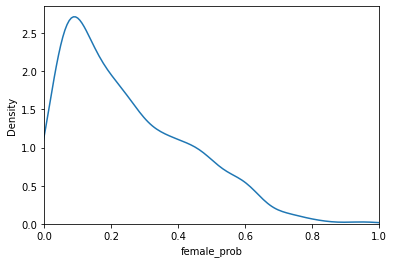

In [80]:
## female_prob
sns.distplot(social_final.loc[social_final['female_prob'].notnull(), 'female_prob'], hist=False)
plt.xlim(0,1)
## 0 : 결측치 / 1 : 0 ~ 0.1 / 2 : 0.1 ~ 0.3 / 3 : 0.3 ~ 0.4 / 4 : 0.4 ~

In [81]:
## 0 : 결측치 / 1 : 0 ~ 0.1 / 2 : 0.1 ~ 0.3 / 3 : 0.3 ~ 0.4 / 4 : 0.4 ~

for i in range(len(social_final['female_prob'])):
    if((social_final['female_prob'][i] >= 0) & (social_final['female_prob'][i] <= 0.1)):
        social_final['female_prob'][i] = 1
    elif((social_final['female_prob'][i] > 0.1) & (social_final['female_prob'][i] <= 0.3)):
        social_final['female_prob'][i] = 2
    elif((social_final['female_prob'][i] > 0.3) & (social_final['female_prob'][i] <= 0.4)):
        social_final['female_prob'][i] = 3
    elif(social_final['female_prob'][i] > 0.4):
        social_final['female_prob'][i] = 4
    else :
        social_final['female_prob'][i] = 0
        
## 각 범주를 가진 기업의 개수가 몇개인지 확인
print(len(social_final.loc[social_final['female_prob'] == 0]))
print(len(social_final.loc[social_final['female_prob'] == 1]))
print(len(social_final.loc[social_final['female_prob'] == 2]))
print(len(social_final.loc[social_final['female_prob'] == 3]))
print(len(social_final.loc[social_final['female_prob'] == 4]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: Se

37
248
355
109
198


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(0.0, 1.0)

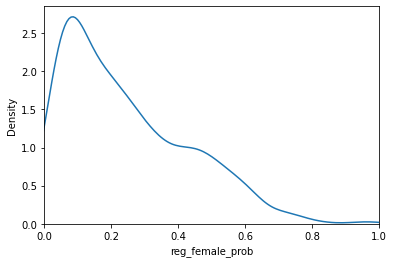

In [82]:
## reg_female_prob
sns.distplot(social_final.loc[social_final['reg_female_prob'].notnull(), 'reg_female_prob'], hist=False)
plt.xlim(0,1)
## 0 : 결측치 / 1 : 0 ~ 0.1 / 2 : 0.1 ~ 0.3 / 3 : 0.3 ~ 0.4 / 4 : 0.4 ~

In [83]:
## 0 : 결측치 / 1 : 0 ~ 0.1 / 2 : 0.1 ~ 0.3 / 3 : 0.3 ~ 0.4 / 4 : 0.4 ~

for i in range(len(social_final['reg_female_prob'])):
    if((social_final['reg_female_prob'][i] >= 0) & (social_final['reg_female_prob'][i] <= 0.1)):
        social_final['reg_female_prob'][i] = 1
    elif((social_final['reg_female_prob'][i] > 0.1) & (social_final['reg_female_prob'][i] <= 0.3)):
        social_final['reg_female_prob'][i] = 2
    elif((social_final['reg_female_prob'][i] > 0.3) & (social_final['reg_female_prob'][i] <= 0.4)):
        social_final['reg_female_prob'][i] = 3
    elif(social_final['reg_female_prob'][i] > 0.4):
        social_final['reg_female_prob'][i] = 4
    else :
        social_final['reg_female_prob'][i] = 0
        
## 각 범주를 가진 기업의 개수가 몇개인지 확인
print(len(social_final.loc[social_final['reg_female_prob'] == 0]))
print(len(social_final.loc[social_final['reg_female_prob'] == 1]))
print(len(social_final.loc[social_final['reg_female_prob'] == 2]))
print(len(social_final.loc[social_final['reg_female_prob'] == 3]))
print(len(social_final.loc[social_final['reg_female_prob'] == 4]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: Se

37
259
351
102
198


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='female_money_prob', ylabel='Density'>

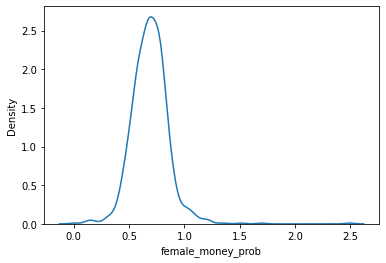

In [84]:
## female_money_prob
sns.distplot(social_final.loc[social_final['female_money_prob'].notnull(), 'female_money_prob'], hist=False)

## 0 : 결측치 / 1 : 0 ~ 0.3 / 2 : 0.3 ~ 0.6 / 3 : 0.6 ~ 0.9 / 4 : 0.9 ~

In [85]:
## 0 : 결측치 / 1 : 0 ~ 0.4 / 2 : 0.4 ~ 0.6 / 3 : 0.6 ~ 0.8 / 4 : 0.8 ~

for i in range(len(social_final['female_money_prob'])):
    if((social_final['female_money_prob'][i] >= 0) & (social_final['female_money_prob'][i] <= 0.4)):
        social_final['female_money_prob'][i] = 1
    elif((social_final['female_money_prob'][i] > 0.4) & (social_final['female_money_prob'][i] <= 0.6)):
        social_final['female_money_prob'][i] = 2
    elif((social_final['female_money_prob'][i] > 0.6) & (social_final['female_money_prob'][i] <= 0.8)):
        social_final['female_money_prob'][i] = 3
    elif(social_final['female_money_prob'][i] > 0.8):
        social_final['female_money_prob'][i] = 4
    else :
        social_final['female_money_prob'][i] = 0
        
## 각 범주를 가진 기업의 개수가 몇개인지 확인
print(len(social_final.loc[social_final['female_money_prob'] == 0]))
print(len(social_final.loc[social_final['female_money_prob'] == 1]))
print(len(social_final.loc[social_final['female_money_prob'] == 2]))
print(len(social_final.loc[social_final['female_money_prob'] == 3]))
print(len(social_final.loc[social_final['female_money_prob'] == 4]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/con

37
21
233
480
176


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(0.0, 1.0)

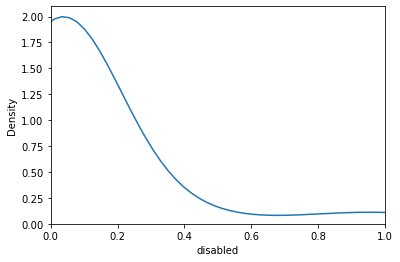

In [86]:
## disabled
sns.distplot(social_final.loc[social_final['disabled'].notnull(), 'disabled'], hist=False)
plt.xlim(0,1)
#############
## 0 : 결측치 / 1 : 0 ~ 0.018 / 2 : 0.018 ~ 0.024 / 3 : 0.024 ~ 0.03 / 4 : 0.03 ~ 0.036 / 5 : 0.036 ~

In [87]:
## 0 : 결측치 / 1 : 0 ~ 0.018 / 2 : 0.018 ~ 0.024 / 3 : 0.024 ~ 0.03 / 4 : 0.03 ~ 0.036 / 5 : 0.036 ~

for i in range(len(social_final['disabled'])):
    if((social_final['disabled'][i] >= 0) & (social_final['disabled'][i] <= 0.018)):
        social_final['disabled'][i] = 1
    elif((social_final['disabled'][i] > 0.018) & (social_final['disabled'][i] <= 0.024)):
        social_final['disabled'][i] = 2
    elif((social_final['disabled'][i] > 0.024) & (social_final['disabled'][i] <= 0.03)):
        social_final['disabled'][i] = 3
    elif((social_final['disabled'][i] > 0.03) & (social_final['disabled'][i] <= 0.036)):
        social_final['disabled'][i] = 4
    elif(social_final['disabled'][i] > 0.036):
        social_final['disabled'][i] = 5
    else :
        social_final['disabled'][i] = 0
        
## 각 범주를 가진 기업의 개수가 몇개인지 확인
print(len(social_final.loc[social_final['disabled'] == 0]))
print(len(social_final.loc[social_final['disabled'] == 1]))
print(len(social_final.loc[social_final['disabled'] == 2]))
print(len(social_final.loc[social_final['disabled'] == 3]))
print(len(social_final.loc[social_final['disabled'] == 4]))
print(len(social_final.loc[social_final['disabled'] == 5]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages

836
34
17
7
7
46


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


0.08200000000000003
0.21799999999999997


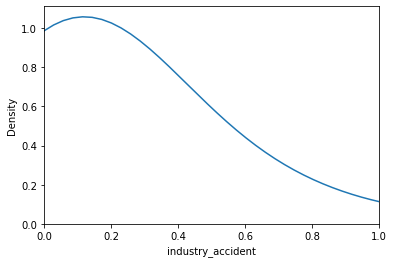

In [88]:
## industry_accident
sns.distplot(social_final.loc[social_final['industry_accident'].notnull(), 'industry_accident'], hist=False)
plt.xlim(0,1)

## 산업재해율은 K-ESG가이드라인에 따르면 평균이상, 평균, 평균미만 세가지 범주로 분류합니다.
## 정확히 평균값을 가지는 기업은 없거나 매우 적기 때문에 저희는 상위 40% , 40-60$ , 60%~ 로 세 범주로 분류하였습니다.
cutoff_low = 0.4
cutoff_high = 0.6
cutoff_low_value = social_final['industry_accident'].quantile(cutoff_low)
cutoff_high_value = social_final['industry_accident'].quantile(cutoff_high)

print(cutoff_low_value)
print(cutoff_high_value)
#############
## 0 : 결측치 / 1 : cutoff_high_value 이상 / 2 : cutoff_low_value 이상 , cutoff_high_value 미만 / 3 : cutoff_low_value 미만

In [89]:
## 0 : 결측치 / 1 : cutoff_high_value 이상 / 2 : cutoff_low_value 이상 , cutoff_high_value 미만 / 3 : cutoff_low_value 미만

for i in range(len(social_final['industry_accident'])):
    if((social_final['industry_accident'][i] > cutoff_high_value)):
        social_final['industry_accident'][i] = 1
    elif((social_final['industry_accident'][i] >= cutoff_low_value) & (social_final['industry_accident'][i] <= cutoff_high_value)):
        social_final['industry_accident'][i] = 2
    elif(social_final['industry_accident'][i] < cutoff_low_value):
        social_final['industry_accident'][i] = 3
    else :
        social_final['industry_accident'][i] = 0
        
## 각 범주를 가진 기업의 개수가 몇개인지 확인
print(len(social_final.loc[social_final['industry_accident'] == 0]))
print(len(social_final.loc[social_final['industry_accident'] == 1]))
print(len(social_final.loc[social_final['industry_accident'] == 2]))
print(len(social_final.loc[social_final['industry_accident'] == 3]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: Se

868
32
15
32


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(0.0, 30.0)

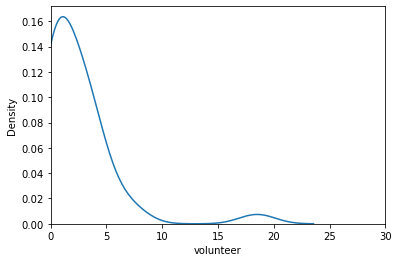

In [90]:
## volunteer
sns.distplot(social_final.loc[social_final['volunteer'].notnull(), 'volunteer'], hist=False)
plt.xlim(0,30)

## 0 : 결측치 / 1 : 0 ~ 2 / 2 : 2 ~ 4 / 3 : 4 ~ 6 / 4 : 6 ~

In [91]:
## 0 : 결측치 / 1 : 0 ~ 2 / 2 : 2 ~ 4 / 3 : 4 ~ 6 / 4 : 6 ~

for i in range(len(social_final['volunteer'])):
    if((social_final['volunteer'][i] >= 0) & (social_final['volunteer'][i] <= 2)):
        social_final['volunteer'][i] = 1
    elif((social_final['volunteer'][i] > 2) & (social_final['volunteer'][i] <= 4)):
        social_final['volunteer'][i] = 2
    elif((social_final['volunteer'][i] > 4) & (social_final['volunteer'][i] <= 6)):
        social_final['volunteer'][i] = 3
    elif(social_final['volunteer'][i] > 6):
        social_final['volunteer'][i] = 4
    else :
        social_final['volunteer'][i] = 0
        
## 각 범주를 가진 기업의 개수가 몇개인지 확인
print(len(social_final.loc[social_final['volunteer'] == 0]))
print(len(social_final.loc[social_final['volunteer'] == 1]))
print(len(social_final.loc[social_final['volunteer'] == 2]))
print(len(social_final.loc[social_final['volunteer'] == 3]))
print(len(social_final.loc[social_final['volunteer'] == 4]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithC

880
35
20
7
5


In [99]:
## 지배구조 데이터 처리
## 먼저, 업종코드가 '64' or '65' 이면 보고서 결측값(투표제 실시 비율 , 이사 출석률 , 이사 찬성률 , 감사위원회 개최 횟수)을
## 해당 asset_sum_cat 범주의 평균값으로 채워준다.

## 왜냐하면, 업종코드가 '64' , '65' 인 경우 지배구조보고서가 아닌 지배구조보고서 및 연차보고서 형식으로 공시하여
## 기존의 지배구조 보고서에서 파생변수를 추출하는 방식으로 데이터를 얻어올 수 없기 때문이다.

govern_final["audit_num"]=pd.to_numeric(govern_final["audit_num"])
asset_mean_data = govern_final.groupby('asset_sum_cat', as_index = False).mean()
asset_mean_data

,asset_sum_cat,Outer_percentage,female_percentage,vote_y,vote_n,vote_percentage,attendance,op_uniformity,audit_num,exist,asset_sum
0,1,0.571208,0.071328,2.180328,4.000000,0.380859,96.391768,99.24279,4.913043,0.919831,1.537673e+13
1,2,0.402468,0.033751,2.060976,4.036585,0.338778,95.588910,97.62194,5.402439,0.354430,7.866093e+11
2,3,0.415614,0.048448,2.750000,3.250000,0.458333,93.089473,99.80000,4.100000,0.084746,3.430930e+11
3,4,0.365375,0.049730,2.000000,4.000000,0.333333,94.816648,100.00000,4.333333,0.012658,1.393970e+11


In [100]:
## 업종코드 64 , 65 번 기업에 대해 결측값 채우기

## ASSET_SUM_CAT으로 나누어진 기업들의 평균값으로 결측치를 채운다.
for i in range(len(govern_final['vote_percentage'])):
    if( (govern_final['industry_med_code'][i] == "'64'") | (govern_final['industry_med_code'][i] == "'65'") ) :
        grade = govern_final['asset_sum_cat'][i]
        govern_final['vote_percentage'][i] = asset_mean_data['vote_percentage'][grade - 1]
        govern_final['attendance'][i] = asset_mean_data['attendance'][grade - 1]
        govern_final['op_uniformity'][i] = asset_mean_data['op_uniformity'][grade - 1]
        govern_final['audit_num'][i] = asset_mean_data['audit_num'][grade - 1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(0.0, 1.0)

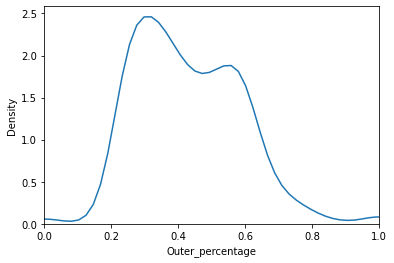

In [101]:
## 지배구조 범주화 시작

## Outer_percentage
sns.distplot(govern_final.loc[govern_final['Outer_percentage'].notnull(), 'Outer_percentage'], hist=False)
plt.xlim(0,1)
## K-ESG가이드라인 기준  0 : 결측치 / 1 : 0 ~ 0.6 / 2 : 0.6 ~ 0.7 / 3 : 0.7 ~ 0.8 / 4 : 0.8 ~

In [102]:
## K-ESG가이드라인 기준  0 : 결측치 / 1 : 0 ~ 0.6 / 2 : 0.6 ~ 0.7 / 3 : 0.7 ~ 0.8 / 4 : 0.8 ~
for i in range(len(govern_final['Outer_percentage'])):
    if((govern_final['Outer_percentage'][i] >= 0) & (govern_final['Outer_percentage'][i] <= 0.6)):
        govern_final['Outer_percentage'][i] = 1
    elif((govern_final['Outer_percentage'][i] > 0.6) & (govern_final['Outer_percentage'][i] <= 0.7)):
        govern_final['Outer_percentage'][i] = 2
    elif((govern_final['Outer_percentage'][i] > 0.7) & (govern_final['Outer_percentage'][i] <= 0.8)):
        govern_final['Outer_percentage'][i] = 3
    elif(govern_final['Outer_percentage'][i] > 0.8):
        govern_final['Outer_percentage'][i] = 4
    else :
        govern_final['Outer_percentage'][i] = 0
        
## 각 범주를 가진 기업의 개수가 몇개인지 확인
print(len(govern_final.loc[govern_final['Outer_percentage'] == 0]))
print(len(govern_final.loc[govern_final['Outer_percentage'] == 1]))
print(len(govern_final.loc[govern_final['Outer_percentage'] == 2]))
print(len(govern_final.loc[govern_final['Outer_percentage'] == 3]))
print(len(govern_final.loc[govern_final['Outer_percentage'] == 4]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: Sett

18
842
43
27
17


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(0.0, 1.0)

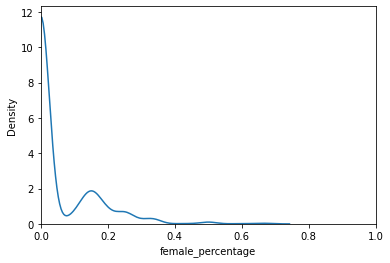

In [103]:
## female_percentage
sns.distplot(govern_final.loc[govern_final['female_percentage'].notnull(), 'female_percentage'], hist=False)
plt.xlim(0,1)
## K-ESG가이드라인 기준  0 : 결측치 / 1 : 0  / 2 : 0 ~ 0.2 / 3 : 0.2 ~ 0.3 / 4 : 0.3 ~

In [104]:
## K-ESG가이드라인 기준  0 : 결측치 / 1 : 0  / 2 : 0 ~ 0.2 / 3 : 0.2 ~ 0.3 / 4 : 0.3 ~
for i in range(len(govern_final['female_percentage'])):
    if((govern_final['female_percentage'][i] == 0)):
        govern_final['female_percentage'][i] = 1
    elif((govern_final['female_percentage'][i] > 0) & (govern_final['female_percentage'][i] <= 0.2)):
        govern_final['female_percentage'][i] = 2
    elif((govern_final['female_percentage'][i] > 0.2) & (govern_final['female_percentage'][i] <= 0.3)):
        govern_final['female_percentage'][i] = 3
    elif(govern_final['female_percentage'][i] > 0.3):
        govern_final['female_percentage'][i] = 4
    else :
        govern_final['female_percentage'][i] = 0

## 각 범주를 가진 기업의 개수가 몇개인지 확인
print(len(govern_final.loc[govern_final['female_percentage'] == 0]))
print(len(govern_final.loc[govern_final['female_percentage'] == 1]))
print(len(govern_final.loc[govern_final['female_percentage'] == 2]))
print(len(govern_final.loc[govern_final['female_percentage'] == 3]))
print(len(govern_final.loc[govern_final['female_percentage'] == 4]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: Sett

12
694
172
43
26


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(70.0, 100.0)

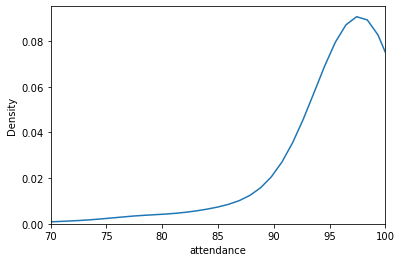

In [105]:
## attendance
sns.distplot(govern_final.loc[govern_final['attendance'].notnull(), 'attendance'], hist=False)
plt.xlim(70,100)
## K-ESG가이드라인 기준  0 : 결측치 / 1 : 0 ~ 75 / 2 : 75 ~ 85 / 3 : 85 ~ 90 / 4 : 90 ~ 95 / 5 : 95 ~

In [106]:
## K-ESG가이드라인 기준  0 : 결측치 / 1 : 0 ~ 75 / 2 : 75 ~ 85 / 3 : 85 ~ 90 / 4 : 90 ~ 95 / 5 : 95 ~
for i in range(len(govern_final['attendance'])):
    if((govern_final['attendance'][i] >= 0) & (govern_final['attendance'][i] <= 75)):
        govern_final['attendance'][i] = 1
    elif((govern_final['attendance'][i] > 75) & (govern_final['attendance'][i] <= 85)):
        govern_final['attendance'][i] = 2
    elif((govern_final['attendance'][i] > 85) & (govern_final['attendance'][i] <= 90)):
        govern_final['attendance'][i] = 3
    elif((govern_final['attendance'][i] > 90) & (govern_final['attendance'][i] <= 95)):
        govern_final['attendance'][i] = 4
    elif(govern_final['attendance'][i] > 95):
        govern_final['attendance'][i] = 5
    else :
        govern_final['attendance'][i] = 0

## 각 범주를 가진 기업의 개수가 몇개인지 확인
print(len(govern_final.loc[govern_final['attendance'] == 0]))
print(len(govern_final.loc[govern_final['attendance'] == 1]))
print(len(govern_final.loc[govern_final['attendance'] == 2]))
print(len(govern_final.loc[govern_final['attendance'] == 3]))
print(len(govern_final.loc[govern_final['attendance'] == 4]))
print(len(govern_final.loc[govern_final['attendance'] == 5]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-pa

614
7
14
15
56
241


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(90.0, 100.0)

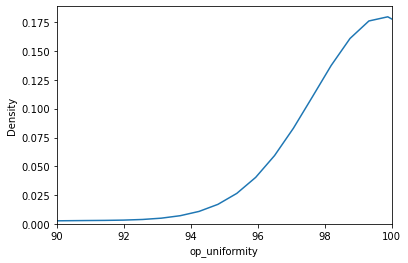

In [107]:
## op_uniformity
sns.distplot(govern_final.loc[govern_final['op_uniformity'].notnull(), 'op_uniformity'], hist=False)
plt.xlim(90,100)
## K-ESG가이드라인 기준  0 : 결측치 / 1 : 100 / 2 : 95 ~ 100 / 3 : ~ 95

In [108]:
## K-ESG가이드라인 기준  0 : 결측치 / 1 : 100 / 2 : 95 ~ 100 / 3 : ~ 95

for i in range(len(govern_final['op_uniformity'])):
    if((govern_final['op_uniformity'][i] == 100)):
        govern_final['op_uniformity'][i] = 1
    elif((govern_final['op_uniformity'][i] >= 95) & (govern_final['op_uniformity'][i] < 100)):
        govern_final['op_uniformity'][i] = 2
    elif((govern_final['op_uniformity'][i] < 95)):
        govern_final['op_uniformity'][i] = 3
    else :
        govern_final['op_uniformity'][i] = 0

## 각 범주를 가진 기업의 개수가 몇개인지 확인
print(len(govern_final.loc[govern_final['op_uniformity'] == 0]))
print(len(govern_final.loc[govern_final['op_uniformity'] == 1]))
print(len(govern_final.loc[govern_final['op_uniformity'] == 2]))
print(len(govern_final.loc[govern_final['op_uniformity'] == 3]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: Se

615
232
88
12


### 4. 최종 결측치 확인 및 출력

In [111]:
environ_final
## 환경을 범주화하지 않아도 되는 이유? 타 변수들은 업종에 상관없이 모든 변수들에 대한 정보들을 맘 먹으면 수집 가능함. 
## 그리고 어떤 업종이든 지배구조, 사회변수들의 중요도는 동일한 수준으로 작용한다고 생각함.
## 그렇지만 환경같은 경우는 업종의 특성상 기재하지 않아도 되는 특수성이 존재.
## 그러면 실제 의무 공시 정보를 제공안한 기업은 어떻게 해야 하나? 그러한 기업들은 업종 변수와 exist 변수를 통해서 걸러질 것이라 예상.

## 이거 끝나면! train, test 만드는 코드 완성!
# e_smote
# e_repeat
# s_smote
# s_repeat
# g_smote
# g_repeat
## 모델 돌리기!

,code,name,market,stock_corp_code,stock_name,kor_name,eng_name,industry_code,industry_med_code,industry_sub_code,...,water,energy,air_pollu,water_pollu,waste,chemical,water_reuse,waste_reuse,exist,asset_sum_cat
0,'000660',SK하이닉스,KOSPI,'00164779',SK하이닉스,에스케이하이닉스(주),SK hynix Inc.,'2612','26','261',...,1.332794e+08,157018.470000,1242.048333,3074.061507,585284.095333,311.695433,4.643436e+07,563472.630667,3,1
1,'035420',NAVER,KOSPI,'00266961',NAVER,네이버(주),NAVER Corporation,'63120','63','631',...,1.694817e+05,2935.713333,0.000000,0.000000,22.260000,0.000000,0.000000e+00,0.000000,3,1
2,'005380',현대차,KOSPI,'00164742',현대자동차,현대자동차(주),HYUNDAI MOTOR CO,'30121','30','301',...,2.730463e+07,62078.844333,736.075530,544.382667,652786.826667,1258.335667,1.717012e+06,575740.015333,3,1
3,'006400',삼성SDI,KOSPI,'00126362',삼성SDI,삼성SDI(주),"SAMSUNG SDI CO.,LTD",'28202','28','282',...,7.198926e+06,22293.564667,85.947243,158.687677,132119.138000,5.969767,6.513193e+05,119577.137667,3,1
4,'068270',셀트리온,KOSPI,'00413046',셀트리온,(주)셀트리온,"Celltrion, Inc.",'21102','21','211',...,9.193513e+05,2024.270333,58.000667,31.832000,3248.163333,0.000000,6.090000e+02,1713.026667,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,'090360',로보스타,KOSDAQ,'00536523',로보스타,(주)로보스타,"Robostar Co.,Ltd.",'29280','29','292',...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0,4
943,'033170',시그네틱스,KOSDAQ,'00158219',시그네틱스,시그네틱스(주),Signetics Corp.,'2612','26','261',...,6.688630e+05,1706.807333,2.288033,2.592000,1454.055333,0.000000,4.062567e+05,236.944000,3,4
944,'060370',KT서브마린,KOSDAQ,'00225742',KT서브마린,(주)케이티서브마린,"KT Submarine Co., Ltd.",'423','42','423',...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0,4
945,'053350',이니텍,KOSDAQ,'00353610',이니텍,이니텍(주),"INITECH Co., Ltd.",'58221','58','582',...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0,4


In [113]:
environ_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code               947 non-null    object 
 1   name               947 non-null    object 
 2   market             947 non-null    object 
 3   stock_corp_code    940 non-null    object 
 4   stock_name         940 non-null    object 
 5   kor_name           940 non-null    object 
 6   eng_name           940 non-null    object 
 7   industry_code      940 non-null    object 
 8   industry_med_code  940 non-null    object 
 9   industry_sub_code  940 non-null    object 
 10  industry_med_name  940 non-null    object 
 11  industry_sub_name  940 non-null    object 
 12  asset_sum          947 non-null    float64
 13  raw                947 non-null    float64
 14  water              947 non-null    float64
 15  energy             947 non-null    float64
 16  air_pollu          947 non

In [114]:
social_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code               947 non-null    object 
 1   name               947 non-null    object 
 2   market             947 non-null    object 
 3   kor_name           940 non-null    object 
 4   eng_name           940 non-null    object 
 5   stock_corp_code    940 non-null    object 
 6   stock_name         940 non-null    object 
 7   industry_code      940 non-null    object 
 8   industry_med_code  940 non-null    object 
 9   industry_sub_code  940 non-null    object 
 10  industry_med_name  940 non-null    object 
 11  industry_sub_name  940 non-null    object 
 12  reg_prob           947 non-null    float64
 13  female_prob        947 non-null    float64
 14  reg_female_prob    947 non-null    float64
 15  female_money_prob  947 non-null    float64
 16  exist              947 non

In [117]:
govern_final

,code,name,market,kor_name,eng_name,stock_corp_code,stock_name,industry_code,industry_med_code,industry_sub_code,...,female_percentage,vote_y,vote_n,vote_percentage,attendance,op_uniformity,audit_num,exist,asset_sum,asset_sum_cat
0,'000660',SK하이닉스,KOSPI,에스케이하이닉스(주),SK hynix Inc.,'00164779',SK하이닉스,'2612','26','261',...,2.0,3.0,3.0,0.500000,5.0,3.0,5.0,True,8.718559e+13,1
1,'035420',NAVER,KOSPI,네이버(주),NAVER Corporation,'00266961',NAVER,'63120','63','631',...,2.0,2.0,4.0,0.333333,4.0,2.0,2.0,True,1.365475e+13,1
2,'005380',현대차,KOSPI,현대자동차(주),HYUNDAI MOTOR CO,'00164742',현대자동차,'30121','30','301',...,2.0,3.0,3.0,0.500000,4.0,1.0,3.0,True,7.878646e+13,1
3,'006400',삼성SDI,KOSPI,삼성SDI(주),"SAMSUNG SDI CO.,LTD",'00126362',삼성SDI,'28202','28','282',...,2.0,2.0,4.0,0.333333,2.0,3.0,8.0,True,1.788154e+13,1
4,'068270',셀트리온,KOSPI,(주)셀트리온,"Celltrion, Inc.",'00413046',셀트리온,'21102','21','211',...,1.0,3.0,3.0,0.500000,2.0,1.0,2.0,True,5.317701e+12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,'090360',로보스타,KOSDAQ,(주)로보스타,"Robostar Co.,Ltd.",'00536523',로보스타,'29280','29','292',...,1.0,NaN,NaN,NaN,0.0,0.0,NaN,False,1.346571e+11,4
943,'033170',시그네틱스,KOSDAQ,시그네틱스(주),Signetics Corp.,'00158219',시그네틱스,'2612','26','261',...,1.0,NaN,NaN,NaN,0.0,0.0,NaN,False,1.872209e+11,4
944,'060370',KT서브마린,KOSDAQ,(주)케이티서브마린,"KT Submarine Co., Ltd.",'00225742',KT서브마린,'423','42','423',...,1.0,NaN,NaN,NaN,0.0,0.0,NaN,False,1.138265e+11,4
945,'053350',이니텍,KOSDAQ,이니텍(주),"INITECH Co., Ltd.",'00353610',이니텍,'58221','58','582',...,1.0,NaN,NaN,NaN,0.0,0.0,NaN,False,1.314195e+11,4


In [118]:
govern_final["audit_num"]=govern_final["audit_num"].fillna(0)
govern_final["vote_percentage"]=govern_final["vote_percentage"].fillna(0)

In [119]:
environ_final.to_csv("data/pipeline3/esg_environ_final_cat.csv",encoding="utf-8",index=False)
govern_final.to_csv("data/pipeline3/esg_govern_final_cat.csv",encoding="utf-8",index=False)
social_final.to_csv("data/pipeline3/esg_social_final_cat.csv",encoding="utf-8",index=False)
to_bigquery(environ_final,"esg_data.esg_environ_final_cat",BUCKET_NAME)
to_bigquery(govern_final,"esg_data.esg_govern_final_cat",BUCKET_NAME)
to_bigquery(social_final,"esg_data.esg_social_final_cat",BUCKET_NAME)